In [8]:
import pandas as pd
import ast

# CSV 파일 불러오기 (인코딩 euc-kr)
csv_path = 'C:/Users/user/metrosafe-1/model/data/api_데이터/날짜합친1호선.csv'
df = pd.read_csv(csv_path, encoding='euc-kr')

# 칸별 혼잡도 리스트로 변환
df['congestionCar'] = df['congestionCar'].apply(ast.literal_eval)

# 최적 칸 인덱스(target) 생성
def get_most_empty_car(cars):
    return cars.index(min(cars))
df['target'] = df['congestionCar'].apply(get_most_empty_car)


In [9]:
from sklearn.preprocessing import LabelEncoder

# 입력 및 타겟 분리
X = df[['호선', '역명', '요일', '시간', '상하행']]
y = df['target']

# 범주형 변수 인코딩
encoders = {}
for col in ['호선', '역명', '요일', '상하행']:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    encoders[col] = le  # 추후 새로운 데이터 전처리용


C:\Users\user\AppData\Local\Temp\ipykernel_18788\386177043.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
C:\Users\user\AppData\Local\Temp\ipykernel_18788\386177043.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
C:\Users\user\AppData\Local\Temp\ipykernel_18788\386177043.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Dataset 정의
class SubwayDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = SubwayDataset(X, y)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# MLP 모델 정의(클래스 수 10개 예시)
class SubwayPredictor(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
    def forward(self, x):
        return self.layers(x)
        
model = SubwayPredictor(input_dim=X.shape[1], num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [11]:
train_loss_list = []

for epoch in range(30):
    running_loss = 0
    for xb, yb in loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(loader)
    train_loss_list.append(epoch_loss)
    print(f"epoch {epoch} loss {epoch_loss:.5f}")


epoch 0 loss 1.43020
epoch 1 loss 1.32238
epoch 2 loss 1.30096
epoch 3 loss 1.28531
epoch 4 loss 1.27447
epoch 5 loss 1.26365
epoch 6 loss 1.25462
epoch 7 loss 1.24725
epoch 8 loss 1.24128
epoch 9 loss 1.23604
epoch 10 loss 1.23165
epoch 11 loss 1.22831
epoch 12 loss 1.22472
epoch 13 loss 1.22126
epoch 14 loss 1.21897
epoch 15 loss 1.21584
epoch 16 loss 1.21356
epoch 17 loss 1.21106
epoch 18 loss 1.20936
epoch 19 loss 1.20655
epoch 20 loss 1.20427
epoch 21 loss 1.20254
epoch 22 loss 1.20076
epoch 23 loss 1.19853
epoch 24 loss 1.19728
epoch 25 loss 1.19536
epoch 26 loss 1.19356
epoch 27 loss 1.19186
epoch 28 loss 1.19049
epoch 29 loss 1.18954


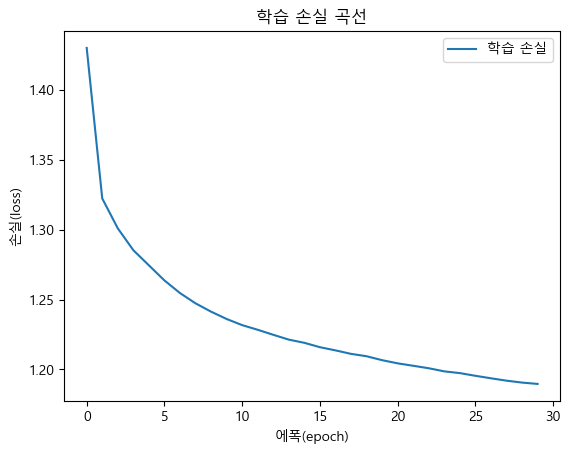

In [12]:
import matplotlib.pyplot as plt

# 한글 폰트 설정 (윈도우: Malgun Gothic)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

plt.plot(train_loss_list, label='학습 손실')
plt.xlabel('에폭(epoch)')
plt.ylabel('손실(loss)')
plt.title('학습 손실 곡선')
plt.legend()
plt.show()


In [13]:
from sklearn.metrics import accuracy_score

model.eval()
with torch.no_grad():
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    y_pred = model(X_tensor)
    pred_labels = torch.argmax(y_pred, dim=1).numpy()
    acc = accuracy_score(y, pred_labels)
    print(f'전체 데이터 정확도: {acc:.4f}')


전체 데이터 정확도: 0.5164


In [14]:
# 모델 파라미터 저장
save_path = 'subway_predictorline1.pt'
torch.save(model.state_dict(), save_path)
print(f'모델이 {save_path}에 저장되었습니다.')


모델이 subway_predictorline1.pt에 저장되었습니다.


In [17]:
import pickle

# encoders: {'호선': LabelEncoder 객체, ...}
with open('label_encodersline1.pkl', 'wb') as f:
    pickle.dump(encoders, f)


In [18]:
import pickle

with open('label_encodersline1.pkl', 'rb') as f:
    encoders = pickle.load(f)
